In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import itertools
from adjustText import adjust_text
import json

In [38]:
rsa = pd.read_csv('../../data/results/rsa.csv')
rsa

,name_i,name_j,spearman,n_words
0,CBOW_GoogleNews,fastText_CommonCrawl,0.631768,42682
1,CBOW_GoogleNews,fastText_Wiki_News,0.538963,42258
2,CBOW_GoogleNews,fastTextSub_OpenSub,0.461915,40062
3,CBOW_GoogleNews,GloVe_CommonCrawl,0.499668,42660
4,CBOW_GoogleNews,GloVe_Twitter,0.219574,32663
...,...,...,...,...
320,EEG_text,fMRI_text_hyper_align,0.194555,537
321,EEG_text,eye_tracking,0.097018,3355
322,fMRI_speech_hyper_align,fMRI_text_hyper_align,0.208698,315
323,fMRI_speech_hyper_align,eye_tracking,0.023719,501


In [39]:
with open('../../data/embed_to_dtype.json', 'r') as f:
    embed_to_dtype = json.load(f)
    
rsa['dtype_i'] = rsa['name_i'].map(embed_to_dtype)
rsa['dtype_j'] = rsa['name_j'].map(embed_to_dtype)

def dtype_corr(dtype_i, dtype_j):
    return rsa.query(
        '(dtype_i == @dtype_i & dtype_j == @dtype_j) | (dtype_i == @dtype_j & dtype_j == @dtype_i)'
    )['spearman'].mean().round(2)

# Self-correlation
text_text, brain_brain, behavior_behavior = dtype_corr('text', 'text'), dtype_corr('brain', 'brain'), dtype_corr('behavior', 'behavior')
print(f'text-text mean correlation {text_text}')
print(f'brain-brain mean correlation {brain_brain}')
print(f'behavior-behavior mean correlation {behavior_behavior}')
print('---------------')

# Self-another
text_brain = dtype_corr('text', 'brain')
print(f'Text-brain mean correlation {text_brain}')
text_behavior = dtype_corr('text', 'behavior')
print(f'Text-behavior mean correlation {text_behavior}')
brain_behavior = dtype_corr('brain', 'behavior')
print(f'Brain-behavior mean correlation {brain_behavior}')

text-text mean correlation 0.41
brain-brain mean correlation 0.12
behavior-behavior mean correlation 0.22
---------------
Text-brain mean correlation 0.09
Text-behavior mean correlation 0.2
Brain-behavior mean correlation 0.03


In [40]:
def to_heat_df(results, col):
    # Heat df template
    names = list(pd.concat([results['name_i'], results['name_j']]).unique()) # needed because not all models guaranteed on one column
    heat_df = pd.DataFrame(index=names, columns=names)

    # Filling with correlations
    query = '(name_i == @name_i & name_j == @name_j) | (name_i == @name_j & name_j == @name_i)'
    for name_i, name_j in list(itertools.combinations(names, 2)):
        r, *_ = results.query(query)[col]
        heat_df.loc[name_i, name_j] = r
        heat_df.loc[name_j, name_i] = r
        
        order = text_names + behavior_names + brain_names

    return heat_df.loc[order, order].astype(float)


with open('../../data/dtype_to_embed.json', 'r') as f:
    dtype_to_embed = json.load(f)

text_names = dtype_to_embed['text']
brain_names = dtype_to_embed['brain']
behavior_names = dtype_to_embed['behavior']

print({dtype: len(names) for dtype, names in dtype_to_embed.items()})

spearmans = to_heat_df(rsa, 'spearman')
spearmans

{'text': 10, 'brain': 6, 'behavior': 10}


,CBOW_GoogleNews,fastText_CommonCrawl,fastText_Wiki_News,fastTextSub_OpenSub,GloVe_CommonCrawl,GloVe_Twitter,GloVe_Wikipedia,LexVec_CommonCrawl,morphoNLM,spherical_text_Wikipedia,...,feature_overlap,norms_sensorimotor,compo_attribs,SVD_sim_rel,microarray,EEG_speech,EEG_text,fMRI_speech_hyper_align,fMRI_text_hyper_align,eye_tracking
CBOW_GoogleNews,NaN,0.631768,0.538963,0.461915,0.499668,0.219574,0.456652,0.498118,0.258314,0.439314,...,0.404074,0.072571,0.299421,0.016124,0.102466,0.055030,0.026408,0.092578,0.089944,0.051538
fastText_CommonCrawl,0.631768,NaN,0.636010,0.504868,0.617937,0.283387,0.451109,0.573953,0.274764,0.449401,...,0.451511,0.104257,0.327320,0.017493,0.072707,0.057026,0.040757,0.092032,0.084546,0.064600
fastText_Wiki_News,0.538963,0.636010,NaN,0.403008,0.519512,0.285297,0.337634,0.391567,0.256870,0.512698,...,0.398742,0.090546,0.280247,0.017061,0.121782,0.083655,0.050267,0.099324,0.124008,0.105981
fastTextSub_OpenSub,0.461915,0.504868,0.403008,NaN,0.419055,0.247239,0.346401,0.428630,0.294002,0.384523,...,0.424574,0.153438,0.349804,0.015131,0.061590,0.052906,0.033202,0.066169,0.077651,0.038228
GloVe_CommonCrawl,0.499668,0.617937,0.519512,0.419055,NaN,0.463426,0.596945,0.667117,0.371129,0.509796,...,0.406886,0.117890,0.377759,0.015297,0.177200,0.101981,0.064198,0.133940,0.160130,0.144123
GloVe_Twitter,0.219574,0.283387,0.285297,0.247239,0.463426,NaN,0.368464,0.346223,0.223618,0.264345,...,0.226574,0.109032,0.262977,0.013462,0.244243,0.117389,0.082213,0.167060,0.208462,0.122550
GloVe_Wikipedia,0.456652,0.451109,0.337634,0.346401,0.596945,0.368464,NaN,0.492453,0.308442,0.362694,...,0.356883,0.034187,0.336125,0.013611,0.197752,0.102164,0.086230,0.161345,0.189002,0.113139
LexVec_CommonCrawl,0.498118,0.573953,0.391567,0.428630,0.667117,0.346223,0.492453,NaN,0.309231,0.371618,...,0.427921,0.148660,0.370547,0.014254,0.108268,0.064237,0.050733,0.103639,0.117088,0.090223
morphoNLM,0.258314,0.274764,0.256870,0.294002,0.371129,0.223618,0.308442,0.309231,NaN,0.321685,...,0.262597,0.106807,0.324353,0.014761,-0.016557,-0.022320,-0.010426,0.003058,-0.024036,0.043238
spherical_text_Wikipedia,0.439314,0.449401,0.512698,0.384523,0.509796,0.264345,0.362694,0.371618,0.321685,NaN,...,0.377174,0.116975,0.341449,0.016945,0.134869,0.092971,0.090272,0.118898,0.154012,0.077191


In [41]:
dissimilarity = 1 - spearmans
np.fill_diagonal(dissimilarity.values, 0.0)

# MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
spearmans_2d = mds.fit_transform(dissimilarity)
spearmans_2d = pd.DataFrame(spearmans_2d, index=spearmans.index)

def data_type(mod_name):
    if mod_name in brain_names:
        return 'brain'
    elif mod_name in behavior_names:
        return 'behavior'
    else:
        return 'text'

# Adding data type
spearmans_2d['embed_type'] = [data_type(name) for name in spearmans_2d.index]
spearmans_2d

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/zhussain/opt/anaconda3/envs/PsychEmbeddings/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


,0,1,embed_type
CBOW_GoogleNews,0.246541,-0.338820,text
fastText_CommonCrawl,0.163881,-0.233169,text
fastText_Wiki_News,0.158332,-0.439563,text
fastTextSub_OpenSub,0.377954,-0.231186,text
GloVe_CommonCrawl,-0.014861,-0.199785,text
GloVe_Twitter,-0.301879,0.030867,text
GloVe_Wikipedia,-0.165485,-0.222137,text
LexVec_CommonCrawl,0.012141,-0.037988,text
morphoNLM,0.223563,-0.628497,text
spherical_text_Wikipedia,-0.006129,-0.452018,text


## Plotting

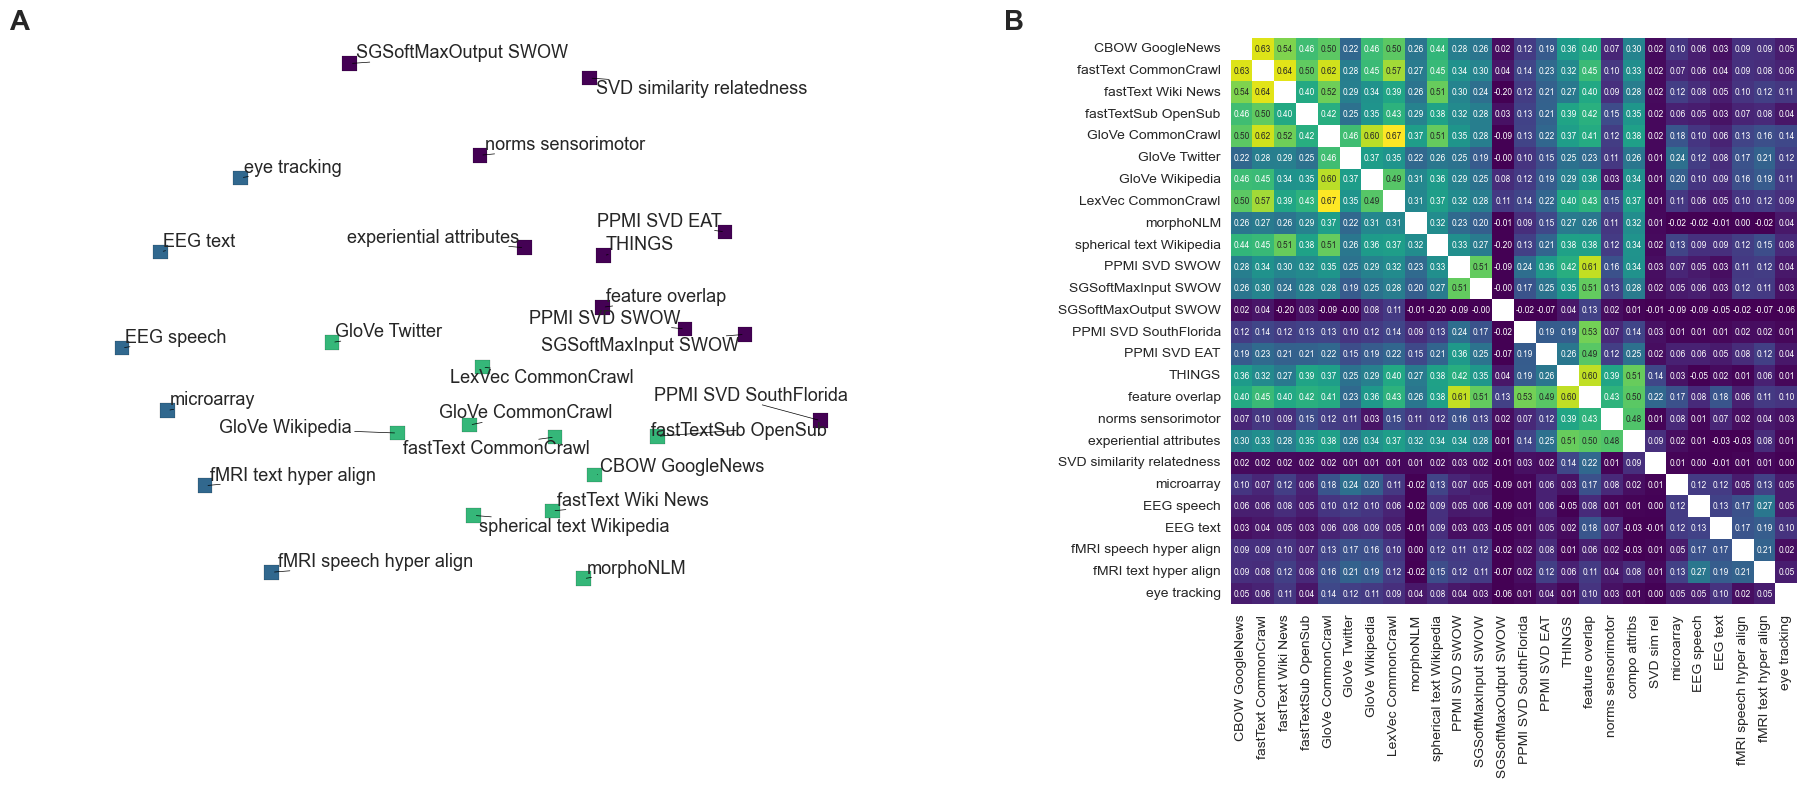

In [42]:
# renaming 'compo_attribs' to 'experiential_attributes'
rename = {'compo_attribs': 'experiential_attributes', 'SVD_sim_rel': 'SVD_similarity_relatedness'}

for df in [spearmans, spearmans_2d]:
    df.index = df.index.to_series().replace(rename).values


fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(20, 8), width_ratios=(0.8, 1))

# Colors
cmap = plt.get_cmap('viridis', 4)
embed_type_to_color = {
    'brain': cmap(1),
    'behavior': cmap(0),
    'text': cmap(2)
}

sns.scatterplot(
    data=spearmans_2d, x=0, y=1, hue='embed_type',
    sizes=(500, 500), legend=False, s=110,
    marker='s', linewidth=0.1, edgecolor='black',
    palette=embed_type_to_color, ax=ax_1
)

ax_1.set(xticklabels='', yticklabels='', xlabel='', ylabel='')

texts = []
for model in spearmans.index:
    texts.append(
        ax_1.text(spearmans_2d[0][model], spearmans_2d[1][model], model.replace('_', ' '), fontsize=13)
    )

# Adjust text labels to avoid overlap
adjust_text(
    texts, arrowprops=dict(arrowstyle='-', color='black', lw=.5), ax=ax_1
)
ax_1.axis('off') # Turn off the axis

# Heatmap 
spearmans.index = spearmans.index.str.replace('_', ' ')
spearmans.columns = spearmans.columns.str.replace('_', ' ')
sns.heatmap(
    spearmans, square=True, annot=True, cmap='viridis',
    vmin=0, vmax=spearmans.max().max(), 
    fmt='.2f', annot_kws={"fontsize": 6}, cbar=False, ax=ax_2
)

# Adding bold panel labels
ax_1.text(-0.1, 1.05, 'A', transform=ax_1.transAxes, fontsize=20, fontweight='bold', va='top')
ax_2.text(-0.4, 1.05, 'B', transform=ax_2.transAxes, fontsize=20, fontweight='bold', va='top')

fig.tight_layout()
plt.savefig('../../figures/rsa.png', dpi=300, bbox_inches='tight')